In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json
Saving test.txt to test.txt
Saving train.txt to train.txt
Saving val.txt to val.txt


{'kaggle.json': b'{"username":"tarunkrishnan36","key":"798270edc5c5fcf952fa1404c43ba4d8"}',
 'test.txt': b'water_body_1628.jpg\nwater_body_720.jpg\nwater_body_1298.jpg\nwater_body_8049.jpg\nwater_body_8743.jpg\nwater_body_7631.jpg\nwater_body_1595.jpg\nwater_body_8482.jpg\nwater_body_7636.jpg\nwater_body_7953.jpg\nwater_body_7286.jpg\nwater_body_7712.jpg\nwater_body_7259.jpg\nwater_body_7288.jpg\nwater_body_8118.jpg\nwater_body_2355.jpg\nwater_body_1157.jpg\nwater_body_8882.jpg\nwater_body_7582.jpg\nwater_body_8736.jpg\nwater_body_8853.jpg\nwater_body_1247.jpg\nwater_body_2383.jpg\nwater_body_8731.jpg\nwater_body_7926.jpg\nwater_body_38.jpg\nwater_body_7802.jpg\nwater_body_7198.jpg\nwater_body_8861.jpg\nwater_body_8704.jpg\nwater_body_1119.jpg\nwater_body_8627.jpg\nwater_body_8.jpg\nwater_body_7830.jpg\nwater_body_1668.jpg\nwater_body_8468.jpg\nwater_body_1351.jpg\nwater_body_638.jpg\nwater_body_7566.jpg\nwater_body_8703.jpg\nwater_body_921.jpg\nwater_body_7727.jpg\nwater_body_7346.jpg

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets list

ref                                                              title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
lainguyn123/student-performance-factors                          Student Performance Factors                          94KB  2024-09-02 10:53:57          18345        338  1.0              
abdulszz/spotify-most-streamed-songs                             Spotify Most Streamed Songs                          60KB  2024-09-07 18:23:14           5068         64  1.0              
owm4096/laptop-prices                                            Laptop Prices                                        25KB  2024-09-09 12:43:01           5600         92  1.0              
cameronseamons/electronic-sales-sep2023-sep2024        

In [6]:
# Step 4: Download dataset
!kaggle datasets download -d franciscoescobar/satellite-images-of-water-bodies

Dataset URL: https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies
License(s): CC-BY-NC-SA-4.0
 99% 244M/247M [00:03<00:00, 55.2MB/s]
100% 247M/247M [00:04<00:00, 64.4MB/s]


In [7]:
# Step 5: Unzip the dataset
!unzip satellite-images-of-water-bodies.zip

Streaming output truncated to the last 5000 lines.
  inflating: Water Bodies Dataset/Images/water_body_1808.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1809.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1810.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1811.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1812.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1813.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1814.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1815.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1816.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1817.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1818.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1819.jpg  
  inflating: Water Bodies Dataset/Images/water_body_182.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1820.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1822.jpg  
  inf

In [8]:
'''import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2
import gc
from tqdm import tqdm

# Define paths to your dataset
IMAGE_PATH = '/content/Water Bodies Dataset/Images'
MASK_PATH = '/content/Water Bodies Dataset/Masks'
IMAGE_SIZE = (256, 256)  # Resize all images to 256x256

# List all images and masks
image_files = sorted([os.path.join(IMAGE_PATH, x) for x in os.listdir(IMAGE_PATH)])
mask_files = sorted([os.path.join(MASK_PATH, x) for x in os.listdir(MASK_PATH)])

# Function to resize and load images in batches
def data_generator(image_files, mask_files, batch_size, image_size):
    while True:
        for i in range(0, len(image_files), batch_size):
            batch_image_files = image_files[i:i + batch_size]
            batch_mask_files = mask_files[i:i + batch_size]

            images = []
            masks = []

            for img_file, mask_file in zip(batch_image_files, batch_mask_files):
                # Load the image and mask
                img = cv2.imread(img_file)
                mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

                # Resize both image and mask
                img = cv2.resize(img, image_size)
                mask = cv2.resize(mask, image_size)

                # Normalize image and binary mask
                img = img / 255.0
                mask = mask / 255.0

                images.append(img)
                masks.append(np.expand_dims(mask, axis=-1))  # Add an extra dimension for the mask

            yield np.array(images), np.array(masks)

# Split the dataset into train, validation, and test sets
image_train, image_test, mask_train, mask_test = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)
image_train, image_val, mask_train, mask_val = train_test_split(image_train, mask_train, test_size=0.2, random_state=42)

# Parameters for data generator
BATCH_SIZE = 8

# Create data generators
train_gen = data_generator(image_train, mask_train, BATCH_SIZE, IMAGE_SIZE)
val_gen = data_generator(image_val, mask_val, BATCH_SIZE, IMAGE_SIZE)
test_gen = data_generator(image_test, mask_test, BATCH_SIZE, IMAGE_SIZE)

# Define the U-Net architecture
def unet_model(input_size):
    inputs = Input(input_size)

    # Encoding path (Contracting)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoding path (Expansive)
    up6 = UpSampling2D(size=(2, 2))(drop5)
    up6 = Conv2D(512, 2, activation='relu', padding='same')(up6)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same')(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same')(up8)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same')(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs, outputs)

    #model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    from tensorflow.keras.metrics import Precision, Recall, MeanIoU

    # Compile the U-Net model with additional metrics
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(), Recall(), MeanIoU(num_classes=2)])



    return model

# Create the U-Net model
input_size = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
model = unet_model(input_size)

# Display the model summary
model.summary()

# Define callbacks
earlystopper = EarlyStopping(patience=10, verbose=1)
#checkpointer = ModelCheckpoint('unet_water_segmentation.h5', verbose=1, save_best_only=True)
checkpointer = ModelCheckpoint('unet_water_segmentation.keras', verbose=1, save_best_only=True)


# Train the model using data generators
steps_per_epoch = len(image_train) // BATCH_SIZE
validation_steps = len(image_val) // BATCH_SIZE

# Train the model using data generators
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[earlystopper, checkpointer]
)

#To download the model, but checkpoint should be saved eitherways
#from google.colab import files
#files.download('unet_water_segmentation.keras')
'''

"import os\nimport numpy as np\nimport tensorflow as tf\nimport matplotlib.pyplot as plt\nfrom tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout\nfrom tensorflow.keras.models import Model\nfrom tensorflow.keras.optimizers import Adam\nfrom sklearn.model_selection import train_test_split\nfrom tensorflow.keras.metrics import MeanIoU\nfrom tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint\nimport cv2\nimport gc\nfrom tqdm import tqdm\n\n# Define paths to your dataset\nIMAGE_PATH = '/content/Water Bodies Dataset/Images'\nMASK_PATH = '/content/Water Bodies Dataset/Masks'\nIMAGE_SIZE = (256, 256)  # Resize all images to 256x256\n\n# List all images and masks\nimage_files = sorted([os.path.join(IMAGE_PATH, x) for x in os.listdir(IMAGE_PATH)])\nmask_files = sorted([os.path.join(MASK_PATH, x) for x in os.listdir(MASK_PATH)])\n\n# Function to resize and load images in batches\ndef data_generator(image_files, mask_files, batch_size, ima

In [9]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2
import gc
from tqdm import tqdm

# Define paths to your dataset
IMAGE_PATH = '/content/Water Bodies Dataset/Images'
MASK_PATH = '/content/Water Bodies Dataset/Masks'
IMAGE_SIZE = (256, 256)  # Resize all images to 256x256

# Helper function to load image and mask names from the text files
def load_file_list(file_path):
    with open(file_path, 'r') as f:
        file_list = f.read().splitlines()
    return file_list

# Load image names from the train.txt, val.txt, and test.txt files
train_image_list = load_file_list('train.txt')
val_image_list = load_file_list('val.txt')
test_image_list = load_file_list('test.txt')

# Append the full path to the image and mask names
def append_paths(image_list, image_path, mask_path):
    images = [os.path.join(image_path, img) for img in image_list]
    masks = [os.path.join(mask_path, img) for img in image_list]
    return images, masks

# Create the full paths for train, val, and test images and masks
image_train, mask_train = append_paths(train_image_list, IMAGE_PATH, MASK_PATH)
image_val, mask_val = append_paths(val_image_list, IMAGE_PATH, MASK_PATH)
image_test, mask_test = append_paths(test_image_list, IMAGE_PATH, MASK_PATH)

# Print the number of train, validation, and test images and masks
num_train = len(image_train)
num_val = len(image_val)
num_test = len(image_test)

print(f"Number of training images: {num_train}")
print(f"Number of validation images: {num_val}")
print(f"Number of test images: {num_test}")

# Calculate and print the percentage splits
total_images = num_train + num_val + num_test
train_split = (num_train / total_images) * 100
val_split = (num_val / total_images) * 100
test_split = (num_test / total_images) * 100

print(f"Train split: {train_split:.2f}%")
print(f"Validation split: {val_split:.2f}%")
print(f"Test split: {test_split:.2f}%")

# Function to resize and load images in batches
def data_generator(image_files, mask_files, batch_size, image_size):
    while True:
        for i in range(0, len(image_files), batch_size):
            batch_image_files = image_files[i:i + batch_size]
            batch_mask_files = mask_files[i:i + batch_size]

            images = []
            masks = []

            for img_file, mask_file in zip(batch_image_files, batch_mask_files):
                # Load the image and mask
                img = cv2.imread(img_file)
                mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

                # Resize both image and mask
                img = cv2.resize(img, image_size)
                mask = cv2.resize(mask, image_size)

                # Normalize image and binary mask
                img = img / 255.0
                mask = mask / 255.0

                images.append(img)
                masks.append(np.expand_dims(mask, axis=-1))  # Add an extra dimension for the mask

            yield np.array(images), np.array(masks)

# Parameters for data generator
BATCH_SIZE = 8

# Create data generators
train_gen = data_generator(image_train, mask_train, BATCH_SIZE, IMAGE_SIZE)
val_gen = data_generator(image_val, mask_val, BATCH_SIZE, IMAGE_SIZE)
test_gen = data_generator(image_test, mask_test, BATCH_SIZE, IMAGE_SIZE)

# Define the U-Net architecture
def unet_model(input_size):
    inputs = Input(input_size)

    # Encoding path (Contracting)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoding path (Expansive)
    up6 = UpSampling2D(size=(2, 2))(drop5)
    up6 = Conv2D(512, 2, activation='relu', padding='same')(up6)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same')(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same')(up8)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same')(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs, outputs)

    # Compile the U-Net model with additional metrics
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(), Recall(), MeanIoU(num_classes=2)])

    return model

# Create the U-Net model
input_size = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
model = unet_model(input_size)

# Display the model summary
model.summary()

# Define callbacks
#earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('unet_water_segmentation.keras', verbose=1, save_best_only=True)

# Train the model using data generators
steps_per_epoch = len(image_train) // BATCH_SIZE
validation_steps = len(image_val) // BATCH_SIZE

# Train the model using data generators
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=50,
    #callbacks=[earlystopper, checkpointer]
    callbacks=[checkpointer]
)

#To download the model, but checkpoint should be saved eitherways
#from google.colab import files
#files.download('unet_water_segmentation.keras')


Number of training images: 1988
Number of validation images: 426
Number of test images: 427
Train split: 69.98%
Validation split: 14.99%
Test split: 15.03%


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 32, 512)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 16, 16, 1024)   │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d        

 Total params: 31,032,837 (118.38 MB)

 Trainable params: 31,032,837 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.5625 - loss: 0.6881 - mean_io_u: 0.2864 - precision: 0.6413 - recall: 0.2267
Epoch 1: val_loss improved from inf to 0.66722, saving model to unet_water_segmentation.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 229s 676ms/step - accuracy: 0.5626 - loss: 0.6880 - mean_io_u: 0.2862 - precision: 0.6415 - recall: 0.2270 - val_accuracy: 0.6221 - val_loss: 0.6672 - val_mean_io_u: 0.3642 - val_precision: 0.6867 - val_recall: 0.4703
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.6335 - loss: 0.6567 - mean_io_u: 0.2863 - precision: 0.7237 - recall: 0.5261
Epoch 2: val_loss improved from 0.66722 to 0.66332, saving model to unet_water_segmentation.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 190s 615ms/step - accuracy: 0.6335 - loss: 0.6567 - mean_io_u: 0.2861 - precision: 0.7237 - recall: 0.5258 - val_accuracy: 0.6099 - val_loss: 0.6633 - val_mean_io_u: 0.3652 - val_precision: 0.8848 - val_recall: 0.1227
Epoch 3/50
248/248 ━━━━━

In [10]:
'''import matplotlib.pyplot as plt

# Assuming 'history' is the output from the fit() method of your model
# which contains the training history metrics

def plot_training_history(history):
    # Get the number of epochs
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12, 8))

    # Plot Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)  # Set x-ticks to integer values for epochs
    plt.legend()

    # Plot Precision
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history.history['precision'], label='Training Precision')
    plt.plot(epochs, history.history['val_precision'], label='Validation Precision')
    plt.title('Model Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.xticks(epochs)  # Set x-ticks to integer values for epochs
    plt.legend()

    # Plot Recall
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history.history['recall'], label='Training Recall')
    plt.plot(epochs, history.history['val_recall'], label='Validation Recall')
    plt.title('Model Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.xticks(epochs)  # Set x-ticks to integer values for epochs
    plt.legend()

    # Plot IoU (MeanIoU)
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history.history['mean_io_u'], label='Training IoU')
    plt.plot(epochs, history.history['val_mean_io_u'], label='Validation IoU')
    plt.title('Model IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.xticks(epochs)  # Set x-ticks to integer values for epochs
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history)
'''

"import matplotlib.pyplot as plt\n\n# Assuming 'history' is the output from the fit() method of your model\n# which contains the training history metrics\n\ndef plot_training_history(history):\n    # Get the number of epochs\n    epochs = range(1, len(history.history['accuracy']) + 1)\n\n    plt.figure(figsize=(12, 8))\n\n    # Plot Accuracy\n    plt.subplot(2, 2, 1)\n    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')\n    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')\n    plt.title('Model Accuracy')\n    plt.xlabel('Epoch')\n    plt.ylabel('Accuracy')\n    plt.xticks(epochs)  # Set x-ticks to integer values for epochs\n    plt.legend()\n\n    # Plot Precision\n    plt.subplot(2, 2, 2)\n    plt.plot(epochs, history.history['precision'], label='Training Precision')\n    plt.plot(epochs, history.history['val_precision'], label='Validation Precision')\n    plt.title('Model Precision')\n    plt.xlabel('Epoch')\n    plt.ylabel('Prec

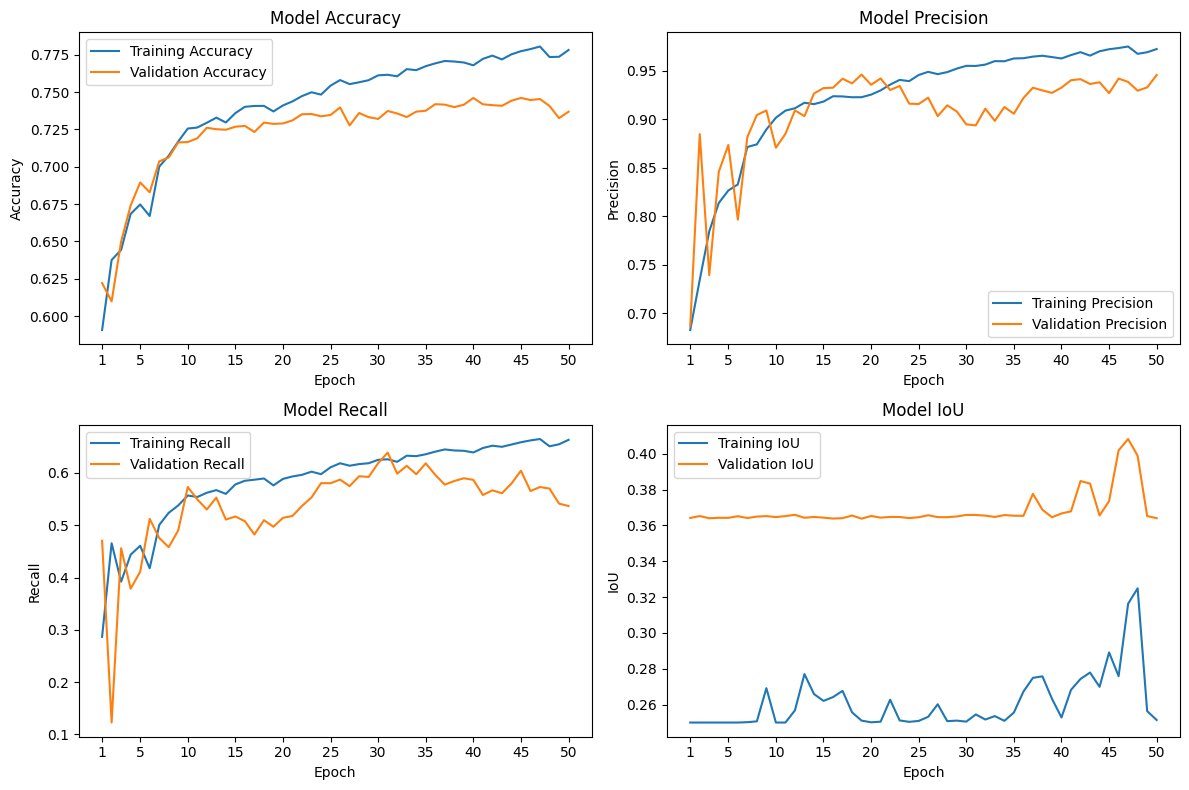

In [11]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Get the number of epochs
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Specify tick values at intervals of 5, starting from 1
    tick_values = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45,50]

    plt.figure(figsize=(12, 8))

    # Plot Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(tick_values)  # Set x-ticks to the desired specific values
    plt.legend()

    # Plot Precision
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history.history['precision'], label='Training Precision')
    plt.plot(epochs, history.history['val_precision'], label='Validation Precision')
    plt.title('Model Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.xticks(tick_values)  # Set x-ticks to the desired specific values
    plt.legend()

    # Plot Recall
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history.history['recall'], label='Training Recall')
    plt.plot(epochs, history.history['val_recall'], label='Validation Recall')
    plt.title('Model Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.xticks(tick_values)  # Set x-ticks to the desired specific values
    plt.legend()

    # Plot IoU (MeanIoU)
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history.history['mean_io_u'], label='Training IoU')
    plt.plot(epochs, history.history['val_mean_io_u'], label='Validation IoU')
    plt.title('Model IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.xticks(tick_values)  # Set x-ticks to the desired specific values
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history)


In [12]:
# Load the trained model
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall, MeanIoU

# Load the model from the saved .keras file
model = load_model('/content/unet_water_segmentation.keras', custom_objects={
    'Precision': Precision(),
    'Recall': Recall(),
    'MeanIoU': MeanIoU(num_classes=2)
})

# Display the model summary to confirm it loaded correctly
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 32, 512)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 16, 16, 1024)   │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d        

 Total params: 93,098,513 (355.14 MB)

 Trainable params: 31,032,837 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,065,676 (236.76 MB)

In [13]:


# Evaluate the model on the test set
test_steps = len(image_test) // BATCH_SIZE
#test_loss, test_acc = model.evaluate(test_gen, steps=test_steps)
#print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')
# Evaluate the model on the test set
test_loss, test_acc, test_precision, test_recall, test_iou = model.evaluate(test_gen, steps=test_steps)

# Print test set results
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test IoU: {test_iou}')


# Clear memory after each epoch to avoid memory overload
gc.collect()

# Predict and visualize some test samples
preds = model.predict(test_gen, steps=test_steps)


53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - accuracy: 0.7556 - loss: 0.3706 - mean_io_u: 0.3958 - precision: 0.9245 - recall: 0.5777
Test Loss: 0.3681238293647766
Test Accuracy: 0.7539260983467102
Test Precision: 0.9302018880844116
Test Recall: 0.5802267789840698
Test IoU: 0.3724806308746338
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 407ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


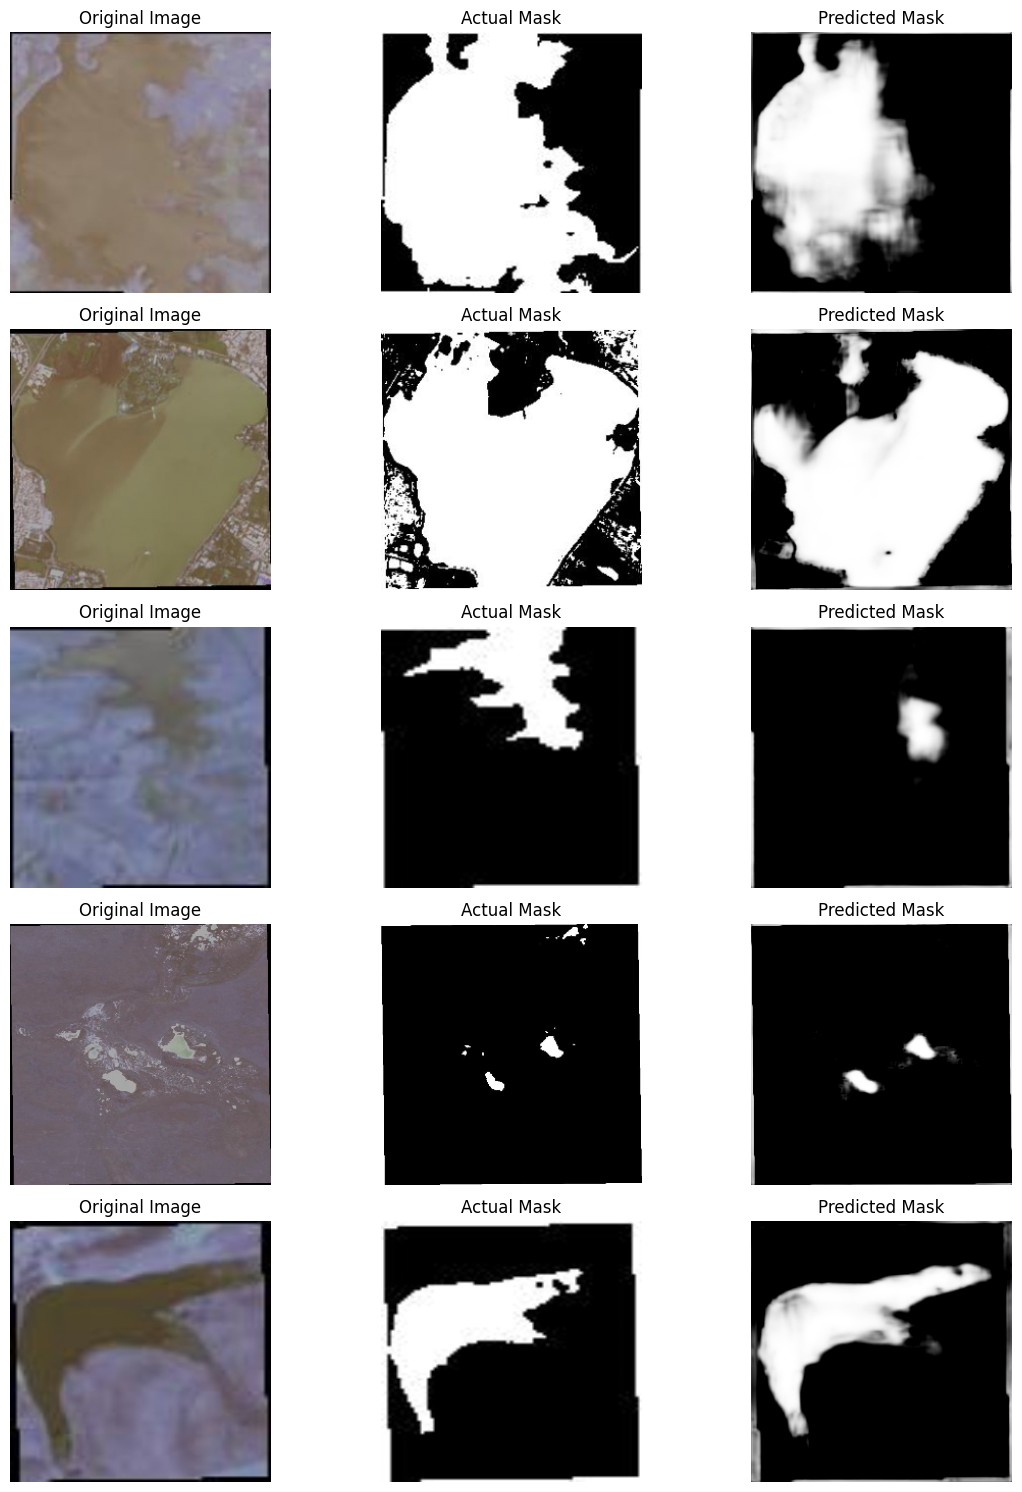

In [15]:
# Predict on a single batch of test data
test_batch = next(test_gen)
test_images, test_masks = test_batch
preds = model.predict(test_images)

# Plot predictions vs actual masks
n = min(5, len(test_images))  # Number of samples to display, up to 5
plt.figure(figsize=(12, 3*n))  # Adjusted figure size for a smaller grid

for i in range(n):
    # Plot the original image
    plt.subplot(n, 3, i*3 + 1)
    plt.imshow(test_images[i])
    plt.title('Original Image')
    plt.axis('off')

    # Plot the actual mask
    plt.subplot(n, 3, i*3 + 2)
    plt.imshow(test_masks[i].squeeze(), cmap='gray')
    plt.title('Actual Mask')
    plt.axis('off')

    # Plot the predicted mask
    plt.subplot(n, 3, i*3 + 3)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout(pad=1.0)  # Adjust padding between subplots
plt.show()